## Step 1: Data Acquisition

# Article Page Views API Example
This example illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). This example shows how to request monthly counts of page views for one specific article. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - May 5, 2022



### Instructions
You will use the same article subset to generate several related data sets. 
All of the data sets are time series of monthly activity. 
For all of the data sets we are only interested in actual user pageview requests. 
The three resulting datasets should be saved as a JSON files ordered using article titles as a key for the resulting time series data. 
You should store You will use the same article subset to generate several related data sets. 
All of the data sets are time series of monthly activity. 
For all of the data sets we are only interested in actual user pageview requests. 
The three resulting datasets should be saved as a JSON files ordered using article titles as a key for the resulting time series data.
You should store the time series data as returned from the API, 
with the exception of removing the ‘access’ field as it is misleading for mobile and cumulative files.
You will produce three files as follows:
Monthly mobile access - The API separates mobile access types into two separate requests, you will need to sum these to make one count for all mobile pageviews. You should store the mobile access data in a file called:
dino_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json
Monthly desktop access - Monthly desktop page traffic is based on one single request. You should store the desktop access data in a file called:
dino_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json
Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. You should store the monthly cumulative data in a file called:
dino_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json
For all of the files the <startYYYYMM> and <endYYYYMM> represent the starting and ending year and month as integer text.


### Collect the articles to use

In [5]:
import pandas as pd

In [6]:
articles=pd.read_csv('dinosaurs.csv')

In [7]:
articles['name'][0]='Coelosaurus antiquus'

In [8]:
articles_list=[x for x in articles.name]

In [9]:
articles.head()

,name,url
0,Coelosaurus antiquus,https://en.wikipedia.org/wiki/”Coelosaurus”_an...
1,Aachenosaurus,https://en.wikipedia.org/wiki/Aachenosaurus
2,Aardonyx,https://en.wikipedia.org/wiki/Aardonyx
3,Abdarainurus,https://en.wikipedia.org/wiki/Abdarainurus
4,Abditosaurus,https://en.wikipedia.org/wiki/Abditosaurus


In [10]:
# 
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import operator

The example relies on some constants that help make the code a bit more readable.

In [15]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<ksahoo@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}
ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

params=[ARTICLE_PAGEVIEWS_PARAMS_DESKTOP,ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB,ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP]

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [16]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace('"','').replace(' ','_'))
    request_template['article'] = article_title_encoded
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [17]:
articles.name[1]

'Aachenosaurus'

In [18]:
print("Getting pageview data for: ",articles.name[0])
views_test = request_pageviews_per_article('joe_biden',request_template=ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB)

Getting pageview data for:  Coelosaurus antiquus


In [249]:
# views

In [232]:
# #print(json.dumps(views,indent=4))
# print("Have %d months of pageview data"%(len(views['items'])))
# for month in views['items']:
#     print(json.dumps(month,indent=4))

In [19]:
data_mobile_app={}
data_desktop={}
data_mobile_web={}
for param in params:
    print(' checking for param {}'.format(param))
    data={'items':[]}
    for article in articles_list:
       #  default=[{'project': 'en.wikipedia',
       # 'article': article,
       # 'granularity': 'monthly',
       # 'timestamp': 'NA',
       # 'access': 'mobile-web',
       # 'agent': 'user',
       # 'views': 0}]
        views = request_pageviews_per_article(article,request_template=param)
        # try:
        # print(views)
        data['items']=data['items']+views['items']
        # except KeyError:
            # data=data+default
        # Serializing json
    data_dict=data
    if param['access']=='mobile-web':
        with open("mobile_web.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_mobile = json.dumps(data_dict, indent=4)
    if param['access']=='desktop':
        with open("desktop.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_desktop = json.dumps(data_dict, indent=4)
    else:
        with open("mobile_app.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_desktop = json.dumps(data_dict, indent=4)
       

 checking for param {'project': 'en.wikipedia.org', 'access': 'desktop', 'agent': 'user', 'article': '', 'granularity': 'monthly', 'start': '2015070100', 'end': '2022093000'}
 checking for param {'project': 'en.wikipedia.org', 'access': 'mobile-web', 'agent': 'user', 'article': 'joe_biden', 'granularity': 'monthly', 'start': '2015070100', 'end': '2022093000'}
 checking for param {'project': 'en.wikipedia.org', 'access': 'mobile-app', 'agent': 'user', 'article': '', 'granularity': 'monthly', 'start': '2015070100', 'end': '2022093000'}


Above output should show dictionaries with views per month

### Convert json to csv

In [23]:
# function to convert json to csv

import json
import csv
def json_to_csv(input_file,output_file):
    
    # Opening JSON file and loading the data
    # into the variable data
    with open(input_file) as json_file:
        data = json.load(json_file)

    dino_data = data['items']
    print(dino_data[2])
    # now we will open a file for writing
    data_file = open(output_file, 'w')

    # create the csv writer object
    csv_writer = csv.writer(data_file)

    # Counter variable used for writing
    # headers to the CSV file
    count = 0

    for dino in dino_data:
        if count == 0:
            # Writing headers of CSV file
            header = dino.keys()
            csv_writer.writerow(header)
            count += 1
        # Writing data of CSV file
        csv_writer.writerow(dino.values())

    data_file.close()

In [24]:
json_to_csv('mobile_web.json','mobile_web.csv')
json_to_csv('mobile_app.json','mobile_app.csv')
json_to_csv('desktop.json','desktop.csv')

{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'mobile-web', 'agent': 'user', 'views': 9}
{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'mobile-app', 'agent': 'user', 'views': 2}
{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'desktop', 'agent': 'user', 'views': 80}


In [27]:
mobile_web=pd.read_csv('mobile_web.csv')
mobile_app=pd.read_csv('mobile_app.csv')
desktop=pd.read_csv('desktop.csv')

In [44]:
mobile_web.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-web,user,16
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-web,user,12
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-web,user,9
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-web,user,21
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-web,user,13


In [29]:
mobile_app.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-app,user,4
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-app,user,2
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-app,user,2
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-app,user,0
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-app,user,0


In [30]:
desktop.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,desktop,user,79
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,desktop,user,62
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,desktop,user,80
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,desktop,user,66
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,desktop,user,72


### combine mobile app and mobile web

In [38]:
mobile=pd.concat([mobile_web,mobile_app],axis=0)

In [37]:
mobile.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-web,user,16
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-web,user,12
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-web,user,9
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-web,user,21
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-web,user,13


In [42]:
mobile_grp=mobile.groupby(by=['project','article','granularity','timestamp','agent']).agg({'views':'sum'}).reset_index()
mobile_grp.columns=['project','article','granularity','timestamp','agent','views']


In [43]:
mobile_grp.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,443
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,412
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,283
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,794
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,311


In [46]:
desktop_grp=desktop.loc[:,['project','article','granularity','timestamp','agent','views']]

In [47]:
desktop_grp.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,user,79
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,user,62
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,user,80
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,user,66
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,user,72


In [48]:
all_access=mobile=pd.concat([mobile_grp,desktop_grp],axis=0)
all_access_grp=all_access.groupby(by=['project','article','granularity','timestamp','agent']).agg({'views':'sum'}).reset_index()
all_access_grp.columns=['project','article','granularity','timestamp','agent','views']

In [49]:
all_access_grp.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,3114
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,13525
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,34518
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,6155
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,13813


### Store everything back in json


In [51]:
def csv_to_json(df, jsonFilePath):
    result = df.to_json(orient="records")
    parsed = json.loads(result)
    with open(jsonFilePath, "w") as outfile:
            json.dump(parsed, outfile)

In [52]:
csv_to_json(mobile_grp,'dino_monthly_mobile_201507-202209.json')
csv_to_json(desktop_grp,'dino_monthly_desktop_201507-202209.json')
csv_to_json(all_access_grp,'dino_monthly_cumulative_201507-202209.json')


## Step 2: Analysis

### Instructions
**Maximum Average and Minimum Average** - The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

**Top 10 Peak Page Views** - The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

**Fewest Months of Data** - The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.


In [58]:
#Maximum Average and Minimum Average for mobile
mobile_grp_avg=mobile_grp.groupby(by=['article']).agg({'views':'mean'}).reset_index()
mobile_grp_avg.columns=['article','avg_views']
mobile_grp_avg=mobile_grp_avg.sort_values(by='avg_views')

In [62]:
mobile_grp_avg.tail()

,article,avg_views
1188,Stegosaurus,21131.471264
1285,Triceratops,21230.701149
1179,Spinosaurus,28958.413793
1327,Velociraptor,42094.091954
1301,Tyrannosaurus,59537.701149


In [63]:
highest_article_mobile=mobile_grp_avg.iloc[-1,0]
lowest_article_mobile=mobile_grp_avg.iloc[0,0]

In [64]:
#Maximum Average and Minimum Average for desktop
desktop_grp_avg=desktop_grp.groupby(by=['article']).agg({'views':'mean'}).reset_index()
desktop_grp_avg.columns=['article','avg_views']
desktop_grp_avg=desktop_grp_avg.sort_values(by='avg_views')

In [66]:
desktop_grp_avg.head()

,article,avg_views
561,Honghesaurus,16.965517
899,Ornithomerus,20.793103
888,Oligosaurus,22.517241
1043,Rachitrema,22.540230
975,Picrodon,24.275862


In [65]:
highest_article_desktop=desktop_grp_avg.iloc[-1,0]
lowest_article_desktop=desktop_grp_avg.iloc[0,0]

In [68]:
#PLot charts
import matplotlib.pyplot as plt

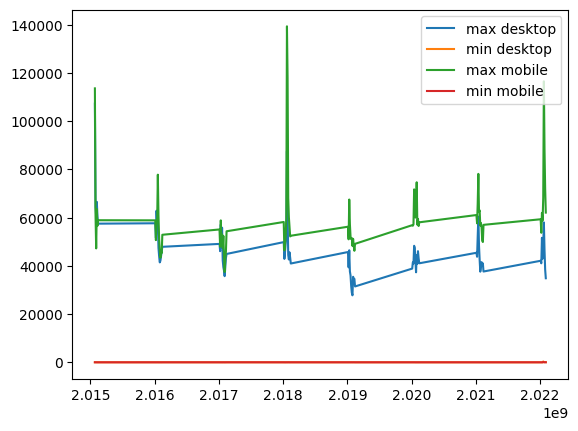

In [77]:
# plot lines
plt.plot(desktop_grp[desktop_grp['article']==highest_article_desktop].timestamp,\
         desktop_grp[desktop_grp['article']==highest_article_desktop].views, label = "max desktop")
plt.plot(desktop_grp[desktop_grp['article']==lowest_article_desktop].timestamp,\
         desktop_grp[desktop_grp['article']==lowest_article_desktop].views, label = "min desktop")
plt.plot(mobile_grp[mobile_grp['article']==highest_article_mobile].timestamp,\
         mobile_grp[mobile_grp['article']==highest_article_mobile].views, label = "max mobile")
plt.plot(mobile_grp[mobile_grp['article']==lowest_article_mobile].timestamp,\
         mobile_grp[mobile_grp['article']==lowest_article_mobile].views, label = "min mobile")

plt.legend()
plt.show()

In [85]:
#top 10 articles for dekstop
m = desktop_grp.groupby('article')['views'].transform('max') == desktop_grp['views']
top_10_desktop=desktop_grp[m].sort_values(by='views',ascending=False).iloc[:10,:]
top_10_desktop

,project,article,granularity,timestamp,agent,views
855,en.wikipedia,Achelousaurus,monthly,2021020100,user,205150
105162,en.wikipedia,Velociraptor,monthly,2015070100,user,135741
103272,en.wikipedia,Tyrannosaurus,monthly,2015070100,user,107257
43310,en.wikipedia,Halszkaraptor,monthly,2017120100,user,103251
40057,en.wikipedia,Giganotosaurus,monthly,2022060100,user,62340
93439,en.wikipedia,Spinosaurus,monthly,2015070100,user,61029
60236,en.wikipedia,Lythronax,monthly,2020060100,user,57701
68436,en.wikipedia,Nigersaurus,monthly,2020020100,user,57192
17187,en.wikipedia,Borealopelta,monthly,2019090100,user,53831
29668,en.wikipedia,Dilophosaurus,monthly,2018060100,user,53278


In [86]:
#top 10 articles for mobile
m = mobile_grp.groupby('article')['views'].transform('max') == mobile_grp['views']
top_10_mobile=mobile_grp[m].sort_values(by='views',ascending=False).iloc[:10,:]
top_10_mobile

,project,article,granularity,timestamp,agent,views
68436,en.wikipedia,Nigersaurus,monthly,2020020100,user,235977
28485,en.wikipedia,Deinocheirus,monthly,2021050100,user,234704
40057,en.wikipedia,Giganotosaurus,monthly,2022060100,user,165007
99962,en.wikipedia,Therizinosaurus,monthly,2022060100,user,155431
105162,en.wikipedia,Velociraptor,monthly,2015070100,user,142284
769,en.wikipedia,Achelousaurus,monthly,2021030100,user,140592
103307,en.wikipedia,Tyrannosaurus,monthly,2018060100,user,139326
17100,en.wikipedia,Borealopelta,monthly,2019090100,user,117282
29716,en.wikipedia,Dilophosaurus,monthly,2022060100,user,78537
9909,en.wikipedia,Argentinosaurus,monthly,2016120100,user,78437


In [88]:
!pip install seaborn


     -------------------------------------- 285.1/285.1 kB 1.9 MB/s eta 0:00:00


In [90]:
import seaborn as sns

<AxesSubplot: xlabel='timestamp', ylabel='views'>

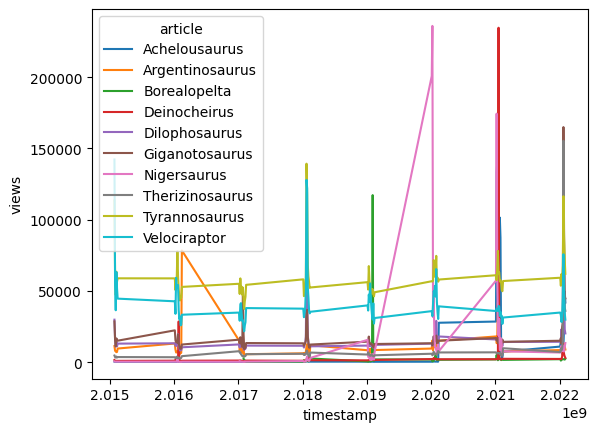

In [107]:
df_top10_mobile=mobile_grp[mobile_grp['article'].isin(list(top_10_mobile.article))]
sns.lineplot(x='timestamp', y='views', errorbar=None,hue='article', data=df_top10_mobile)

<AxesSubplot: xlabel='timestamp', ylabel='views'>

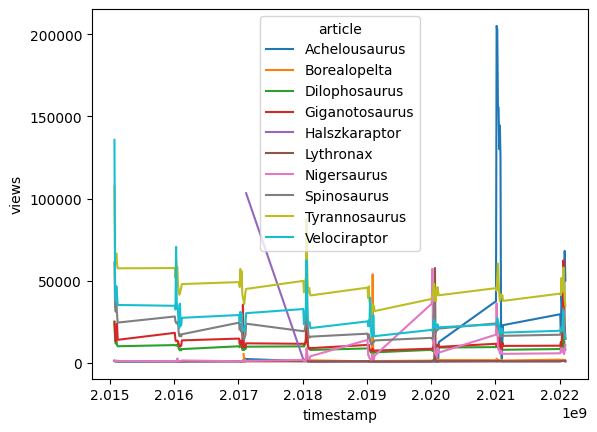

In [110]:
df_top10_desktop=desktop_grp[desktop_grp['article'].isin(list(top_10_desktop.article))]
sns.lineplot(x='timestamp', y='views', errorbar=None,hue='article', data=df_top10_desktop)

In [109]:
df_top10_desktop

,project,article,granularity,timestamp,agent,views
788,en.wikipedia,Achelousaurus,monthly,2015070100,user,1181
789,en.wikipedia,Achelousaurus,monthly,2015080100,user,703
790,en.wikipedia,Achelousaurus,monthly,2015090100,user,699
791,en.wikipedia,Achelousaurus,monthly,2015100100,user,708
792,en.wikipedia,Achelousaurus,monthly,2015110100,user,691
...,...,...,...,...,...,...
105244,en.wikipedia,Velociraptor,monthly,2022050100,user,25219
105245,en.wikipedia,Velociraptor,monthly,2022060100,user,31520
105246,en.wikipedia,Velociraptor,monthly,2022070100,user,20092
105247,en.wikipedia,Velociraptor,monthly,2022080100,user,16691


In [113]:
#Fewest months of data
mobile_grp_count_months=mobile_grp.groupby(by=['article']).agg({'timestamp':'nunique'}).reset_index()
mobile_grp_count_months.columns=['article','months_count']
mobile_grp_count_months=mobile_grp_count_months.sort_values(by='months_count').iloc[:10]

In [114]:
mobile_grp_count_months

,article,months_count
414,Elemgasem,1
1295,Tuebingosaurus,1
617,Jakapil,2
791,Mbiresaurus,2
966,Perijasaurus,2
208,Bisticeratops,2
615,Iyuku,3
938,Paralitherizinosaurus,5
189,Bashanosaurus,7
403,Dzharaonyx,7


In [115]:
#Fewest months of data
desktop_grp_count_months=desktop_grp.groupby(by=['article']).agg({'timestamp':'nunique'}).reset_index()
desktop_grp_count_months.columns=['article','months_count']
desktop_grp_count_months=desktop_grp_count_months.sort_values(by='months_count').iloc[:10]

In [116]:
desktop_grp_count_months

,article,months_count
414,Elemgasem,1
1295,Tuebingosaurus,1
617,Jakapil,2
791,Mbiresaurus,2
966,Perijasaurus,2
208,Bisticeratops,2
615,Iyuku,3
938,Paralitherizinosaurus,5
189,Bashanosaurus,7
403,Dzharaonyx,7


<AxesSubplot: xlabel='timestamp', ylabel='views'>

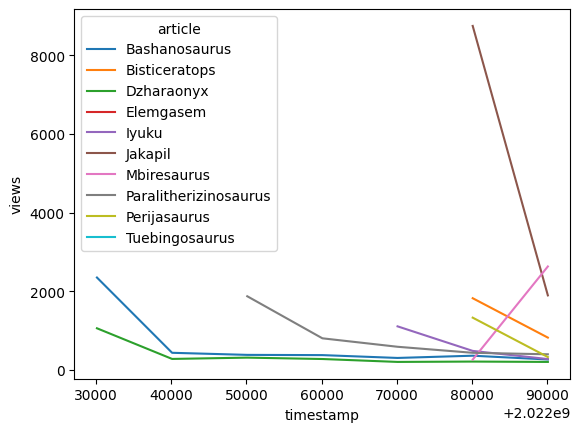

In [117]:
df_min_mths_desktop=desktop_grp[desktop_grp['article'].isin(list(desktop_grp_count_months.article))]
sns.lineplot(x='timestamp', y='views', errorbar=None,hue='article', data=df_min_mths_desktop)

<AxesSubplot: xlabel='timestamp', ylabel='views'>

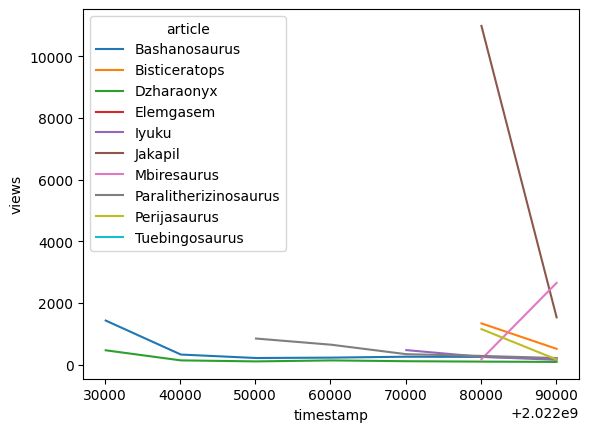

In [118]:
df_min_mths_mobile=mobile_grp[mobile_grp['article'].isin(list(mobile_grp_count_months.article))]
sns.lineplot(x='timestamp', y='views', errorbar=None,hue='article', data=df_min_mths_mobile)